In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import imp
import sys
sys.path.append('/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
from elephant.spike_train_surrogates import * 
from elephant.statistics import mean_firing_rate, cv, isi
from quantities import Hz, ms
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

#### Load functions for validation tools and visualization

In [3]:
%%capture
dist = imp.load_source('*', './validation/dist.py')
matstat = imp.load_source('*', './validation/matrix.py')
testdata = imp.load_source('*', './validation/test_data.py')
vizi = imp.load_source('*', '../INM6/Tasks/viziphant/plots/generic.py')

data_path = '/home/robin/Projects/ValidationTools'
nest_path = data_path + "/sim_data/NEST_data"
spinnaker_path = data_path + "/sim_data/SpiNNaker_data"

# Number of spiketrains:
N = 100

#### Load spiketrains from simulation

spiketrain_list_1 = testdata.load_data(nest_path, ['spikes_L4'], N)[0][0]

spiketrain_list_2 = testdata.load_data(spinnaker_path, ['spikes_L4'], N)[0][0]

#### ...or generate custom spiketrains

In [4]:
spiketrain_list_1 = testdata.test_data(size=N, 
                                       corr=.0, 
                                       t_stop=500*ms, 
                                       rate=100*Hz, 
                                      #assembly_sizes=[10,5,3],
                                       method="CPP", 
                                       bkgr_corr=0.00)

spiketrain_list_2 = testdata.test_data(size=N, 
                                       corr=[.2], 
                                       t_stop=500*ms, 
                                       rate=100*Hz, 
                                       assembly_sizes=[10],
                                       method="CPP", 
                                       bkgr_corr=0.00)

#### Rasterplots

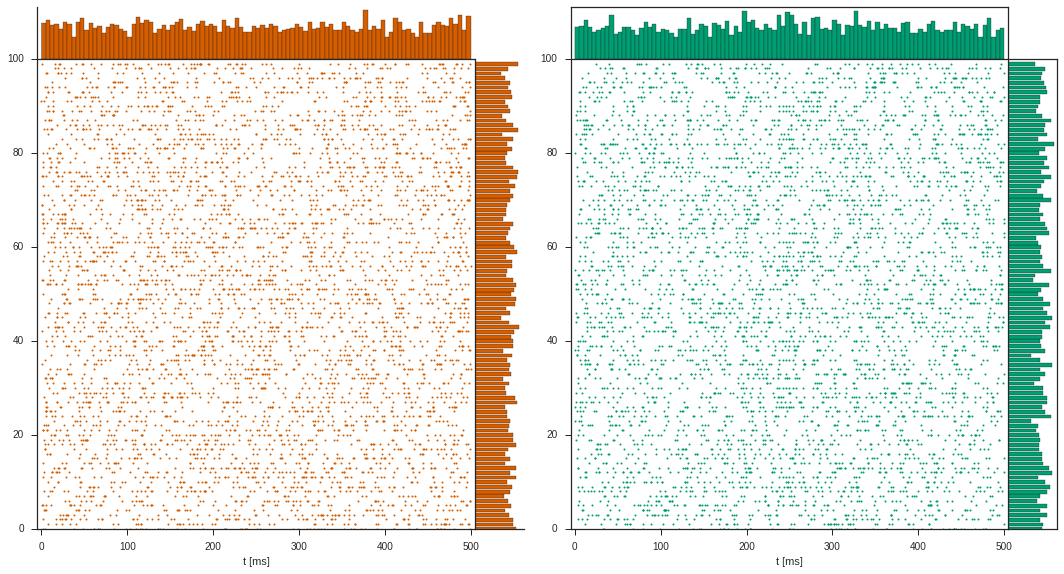

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
fig.tight_layout()

__ = vizi.rasterplot(spiketrain_list_1, ax=ax[0], palette=(['r']))
__ = vizi.rasterplot(spiketrain_list_2, ax=ax[1], palette=(['g']))

### Compare distributions 
##### of CVs, firing rates, correlation coefficients, ...

In [6]:
def func(sts):
    return matstat.corr_matrix(sts).flatten() # cv(isi(x)), mean_firing_rate(x)
    
dist_sample_1 = func(spiketrain_list_1)

dist_sample_2 = func(spiketrain_list_2)

#### Kullback-Leibler Divergence

$$ D_\mathrm{KL}(P||Q) =\sum_{i} P(i) \log_2 \frac{P(i)}{Q(i)} = H(P,Q) - H(P)$$
$ $

The KL-Divergence is a measure of difference between two distribution based on entropy.

When $P$ can be regarded as reference, $D_\mathrm{KL}$ is the amount of information lost when substituting $Q$ for $P$. Consequently this measure is asymetric.


Kullback-Leidler-Divergence
	Interpreting input as data sample...
	64 zero values have been discarded.
	D_KL(P||Q) = 0.01
	D_KL(Q||P) = 0.01



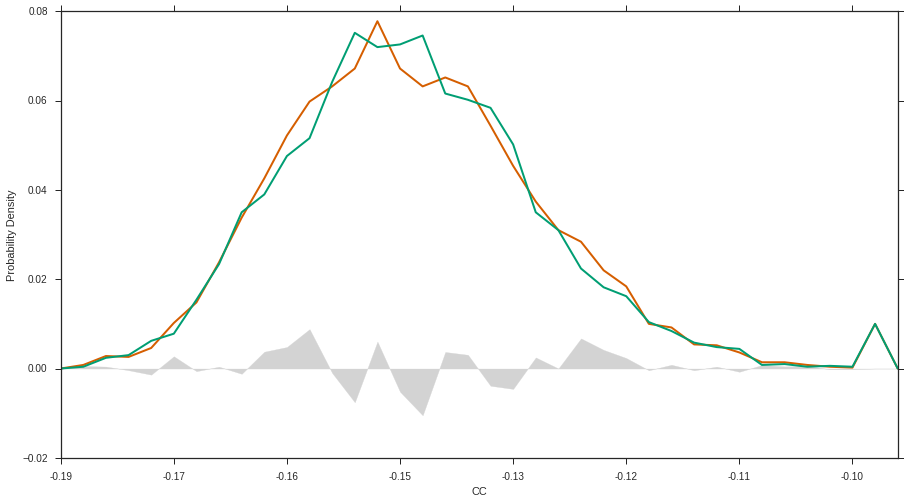

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
DKL, DKL_inv = dist.KL_test(dist_sample_1, dist_sample_2, ax=ax, bins=100, excl_zeros=True, xlabel='CC')

#### Kolmogorov-Smirnov Distance

$$ D_\mathrm{KS} = \sup | \hat{P}(x) - \hat{Q}(x) | $$
$ $

The KS-Distance measures the maximal vertical distance of the cumulative distributions $\hat{P}$ and $\hat{Q}$. This is a sensitive tool for detecting differences in mean, variance or distribution type. But it can't well detect deviations in the tails of the distributions. A possibily more powerful alternative would be the Cramér-von-Mises Test.

$ $

The null hypothesis that the underlying distributions are identical is rejected when the $D_\mathrm{KS}$ statistic is larger than a critical value $D_\alpha$ or equivalently when the correponding p-value is less than the signficance level $\alpha$.


Kolmogorov-Smirnov-Distance
	length 1 = 10000 	 length 2 = 10000
	D_KS = 0.02 	 p value = 0.03



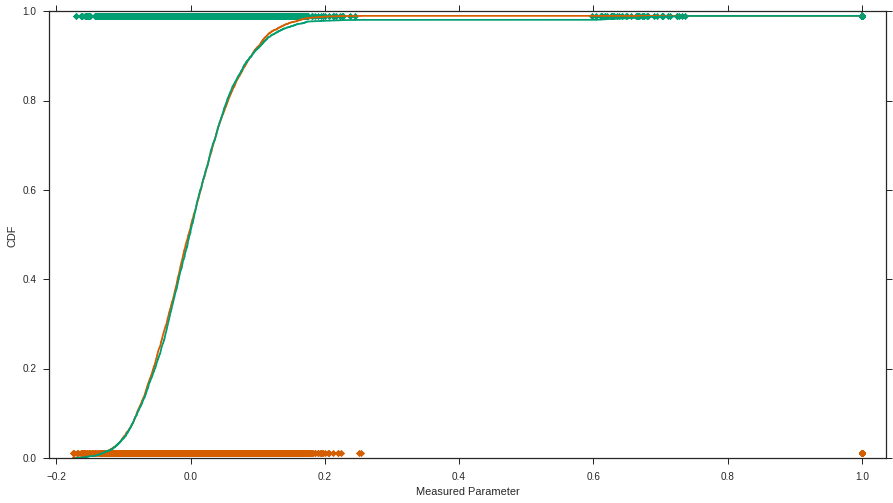

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
DKS, p = dist.KS_test(dist_sample_1, dist_sample_2, ax=ax)

#### Mann-Whitney U Test

$$ U_i = R_i - \frac{n_i(n_i + 1)}{2}\\ U = min(U_1,U_2) $$

$R_i$: rank sum

$n_i$: sample size

$ $

The Mann-Whitney U is a rank statistic which test the null hypothesis that a random value of sample 1 is equally likely to be larger or a smaller value than a randomly chosen value of sample 2.

$ $

The $U_i$ statistic is in the range of $[0,n_1 n_2]$, and the $U=min(U_1,U_2)$ statistic is in the range of $[0,\frac{n_1 n_2}{2}]$.

$ $

For sample sizes $>20$ $U$ follows approximately a normal distribution. With this assumption a p-value can be inferred. The null hypothesis is consequently rejected when the p-value is less than the significance level.


Mann-Whitney-U-Test
	length 1 = 100 	 length 2 = 100
	U = 4510.50   	 p value = 0.23


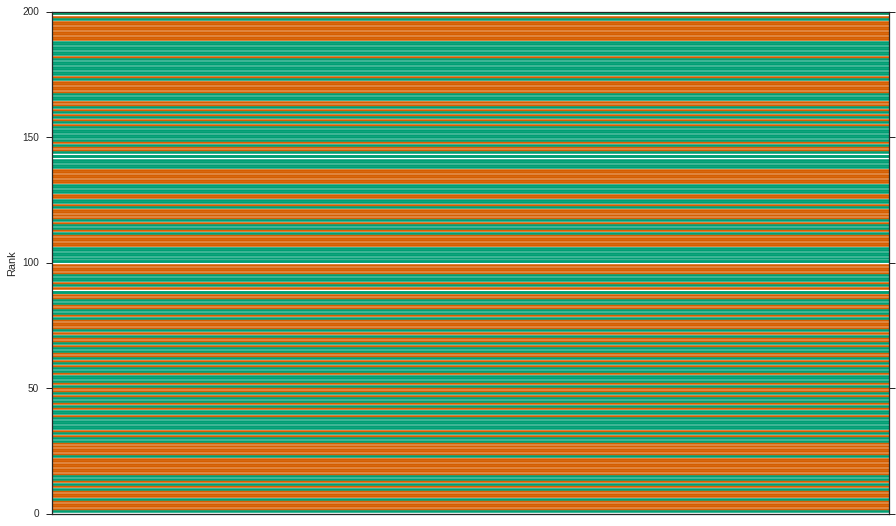

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,9))
U, p = dist.MWU_test(dist_sample_1[:100], dist_sample_2[:100], ax=ax, excl_nan=True)

### Compare the correlation matrices

#### Heatmap

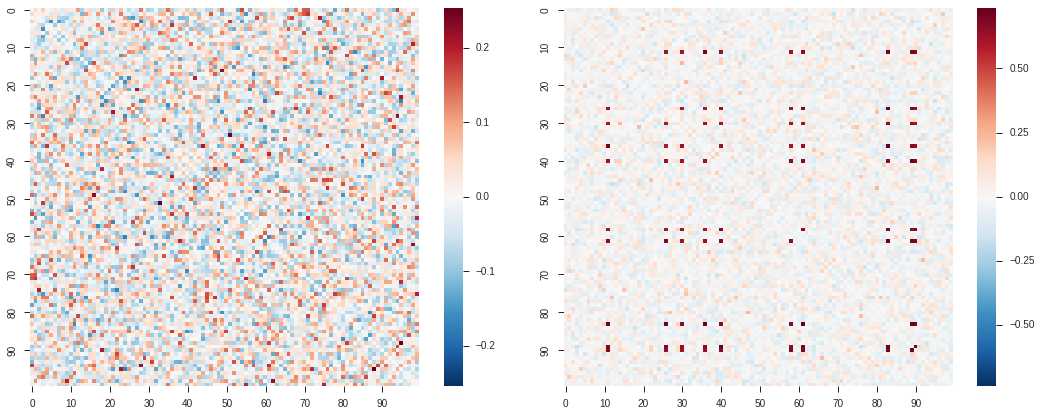

In [10]:
corr_matrix_1 = matstat.corr_matrix(spiketrain_list_1)
corr_matrix_2 = matstat.corr_matrix(spiketrain_list_2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()
matstat.plot_matrix(corr_matrix_1, ax[0], remove_autocorr=True)
matstat.plot_matrix(corr_matrix_2, ax[1], remove_autocorr=True)

#### Eigenvalue distribution


Eigenvalue distribution:
	EW_max = 2.63
	EW_min = 0.16

Redundancy = 0.06 


Eigenvalue distribution:
	EW_max = 7.34
	EW_min = 0.10

Redundancy = 0.09 



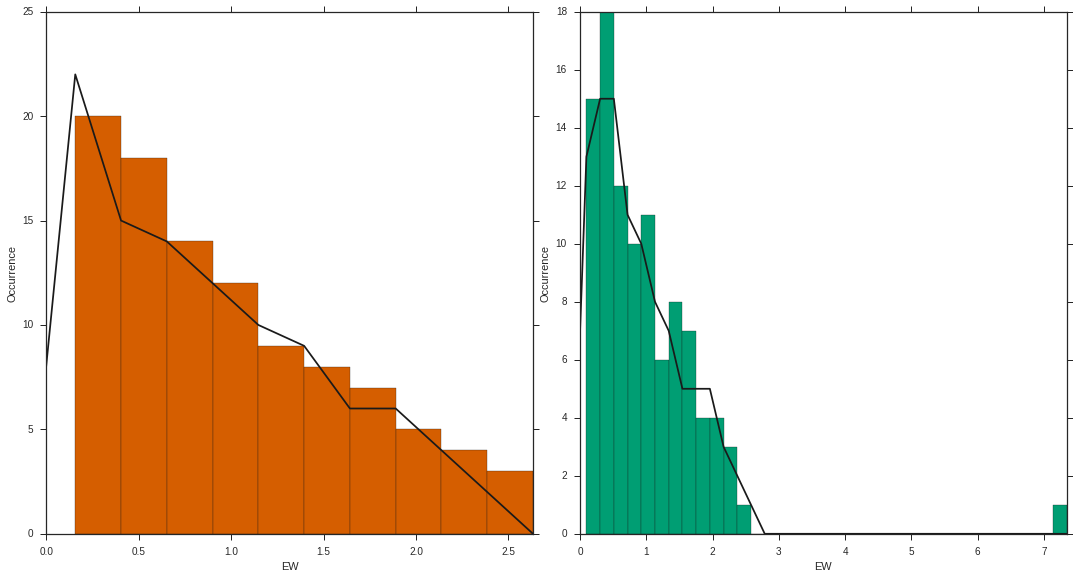

In [11]:
EWs_1, EVs_1 = eigh(corr_matrix_1)
EWs_2, EVs_2 = eigh(corr_matrix_2)

# Generate surrogates as reference
def generate_ref(spiketrain_list):
    surrogate_spiketrain_list = testdata.generate_surrogates(spiketrain_list, 
                                                             dither_spikes, #_train, 
                                                             dither=10*ms) #shift
    surrogate_corr_matrix = matstat.corr_matrix(surrogate_spiketrain_list)
    return eigh(surrogate_corr_matrix)[0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
fig.tight_layout()
__ = matstat.eigenvalue_distribution(EWs_1, ax[0], 
                                     reference_EWs=generate_ref(spiketrain_list_1),
                                     binnum=int(max(EWs_1))*5, color='r')
__ = matstat.redundancy(EWs_1)

__ = matstat.eigenvalue_distribution(EWs_2, ax[1], 
                                     reference_EWs=generate_ref(spiketrain_list_2),
                                     binnum=int(max(EWs_2))*5, color='g')
__ = matstat.redundancy(EWs_2)

#### Eigenvalue spectra


Significance Test:
	Method: SCREE 
	6 of 100 eigenvalues are significant

Princial components:
	0: 2.63
	1: 2.45
	2: 2.40
	3: 2.35
	4: 2.25
	5: 2.20


Significance Test:
	Method: SCREE 
	4 of 100 eigenvalues are significant

Princial components:
	0: 7.34
	1: 2.45
	2: 2.36
	3: 2.28



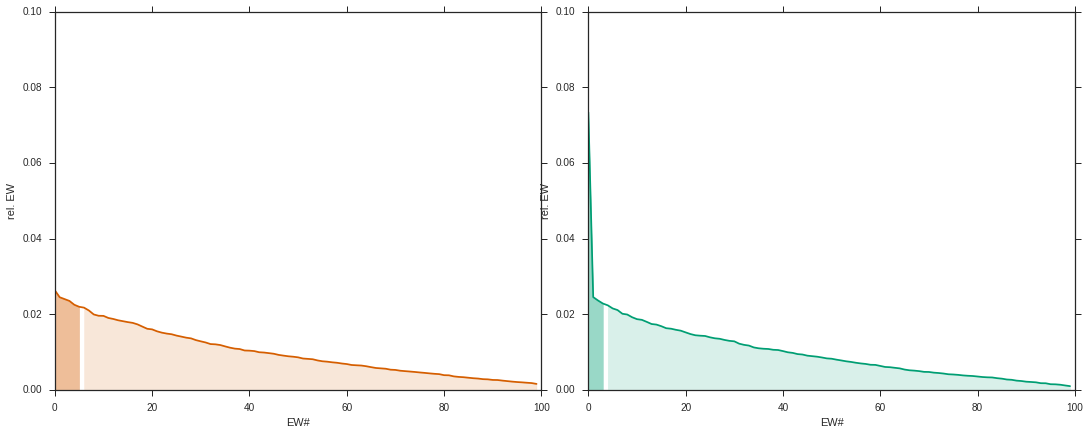

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

pc_nbr_1 = matstat.eigenvalue_spectra(EWs_1, method='SCREE', alpha=.20, ax=ax[0], color='r')
pc_nbr_2 = matstat.eigenvalue_spectra(EWs_2, method='SCREE', ax=ax[1], color='g')

#### Show eigenvectors

In [13]:
if N < 17:
    colormap = [37,37,30,34,32,31,33,36,35] + [47,40,44,42,41,43,46,45]
    matstat.print_eigenvectors(EVs_1, EWs_1, pc_nbr_1, colormap=colormap)
    matstat.print_eigenvectors(EVs_2, EWs_2, pc_nbr_2, colormap=colormap)

#### Angles between eigenspaces

In [14]:
nbr_of_pcs = min(pc_nbr_1, pc_nbr_2)
_ = matstat.EV_angles(EVs_1[:, -nbr_of_pcs:], EVs_2[:, -nbr_of_pcs:])


Angles between the eigenvectors
	68.67°
	49.86°
	54.15°
	52.40°

Angle between eigenspaces
	89.99°


#### Detect Assemblies

In [15]:
print "\033[36mSample 1\033[0m\n"
corr_order_1 = matstat.detect_assemblies(EVs_1, EWs_1, detect_by='eigenvalues', sort=True, jupyter=True)
print "\033[36mSample 2\033[0m\n"
corr_order_2 = matstat.detect_assemblies(EVs_2, EWs_2, detect_by='eigenvalues', EW_lim=3, sort=True, jupyter=True)

Sample 1

Assembly 1, eigenvalue 2.63, size 3
Neuron ID:	13	95	65		Norm
Portion:	0.27	0.23	0.22		0.42

Assembly 2, eigenvalue 2.45, size 3
Neuron ID:	43	21	24		Norm
Portion:	0.24	0.21	0.19		0.38

Assembly 3, eigenvalue 2.40, size 3
Neuron ID:	27	61	45		Norm
Portion:	0.27	0.26	0.22		0.44

Assembly 4, eigenvalue 2.35, size 3
Neuron ID:	55	75	80		Norm
Portion:	0.26	0.24	0.23		0.43

Assembly 5, eigenvalue 2.25, size 3
Neuron ID:	93	31	70		Norm
Portion:	0.26	0.24	0.23		0.42

Assembly 6, eigenvalue 2.20, size 3
Neuron ID:	23	47	77		Norm
Portion:	0.29	0.25	0.24		0.45

Assembly 7, eigenvalue 2.17, size 3
Neuron ID:	50	41	92		Norm
Portion:	0.24	0.23	0.22		0.40

Assembly 8, eigenvalue 2.10, size 3
Neuron ID:	91	22	88		Norm
Portion:	0.25	0.23	0.23		0.41

Sample 2

Assembly 1, eigenvalue 7.34, size 8
Neuron ID:	83	89	61	90	40	11	26	36		Norm
Portion:	0.32	0.32	0.31	0.31	0.31	0.30	0.30	0.30		0.88



#### Show Assemblies in Correlation Matrix

([array([ 0.32366487,  0.32028194,  0.31174901,  0.309457  ,  0.30578199,
        0.30362628,  0.30105332,  0.30050141])], [83, 89, 61, 90, 40, 11, 26, 36, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97, 98, 99])


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

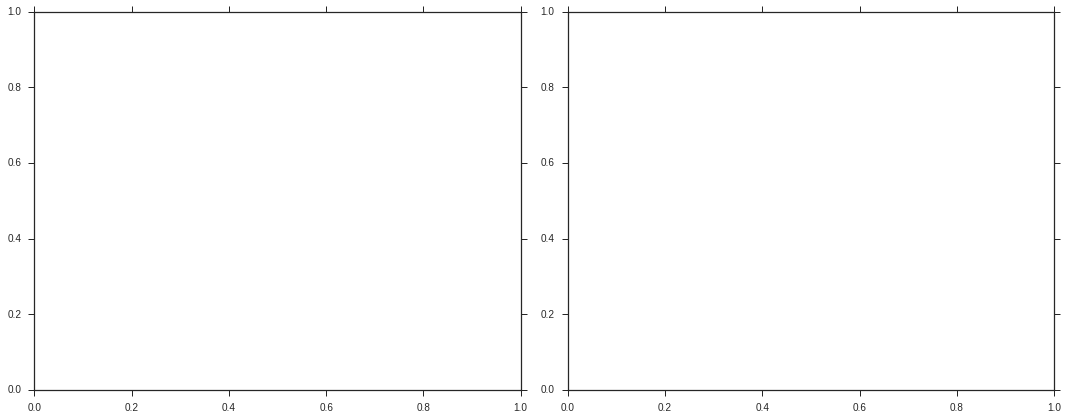

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

print corr_order_2

matstat.plot_matrix(corr_matrix_1[corr_order_1, :][:, corr_order_1], ax[0], labels=corr_order_1, remove_autocorr=False)
matstat.plot_matrix(corr_matrix_2[corr_order_2, :][:, corr_order_2], ax[1], labels=corr_order_2, remove_autocorr=False)